## Here we demonstrate how Gamma scalping works by delta-hedging a long-gamma option (such as a call)

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


### Standard Black-Scholes value for a call

In [2]:
def black_scholes_call(asof, asset_spot, asset_vol, option_strike, option_expiry, calc_gamma = False):
    '''
    Calculate the value, delta and gamma of a call option in Black-Scholes model
    Assume zero rates and dividend yield
    One of the arguments could be a numpy array
    asof            : observation time in years, "little t" (normally 0 but useful to have as an input for hedging sim
                      as it moves forward while expiry stays fixed)
    asset_spot      : asset spot
    asset_vol       : asset lognormal volatility
    option_strike   : option strike
    option_expiry   : option expiry in years, "large T"
    calc_gamma      : do we really need Gamma? Save some calcs if we do not
 
    Returns:        : (value, delta, gamma)
    '''
    tau = option_expiry - asof
 
    # basic edge case handling
    asset_vol = np.maximum(asset_vol, 1e-4)
    tau  = np.maximum(tau, 1e-4)
    asset_spot = np.maximum(asset_spot, 1e-4)
 
    voltau = asset_vol*np.sqrt(tau)
   
    d1 = (np.log(asset_spot/option_strike) + voltau*voltau/2.0)/voltau
    d2 = d1 - voltau
 
    delta = norm.cdf(d1)
    value = asset_spot * delta - option_strike*norm.cdf(d2)
    gamma = norm.pdf(
        d1)/(asset_spot * voltau) if calc_gamma else np.zeros_like(asset_spot/strike * voltau)
 
    return value, delta, gamma

### Check if our call pricer  looks ok

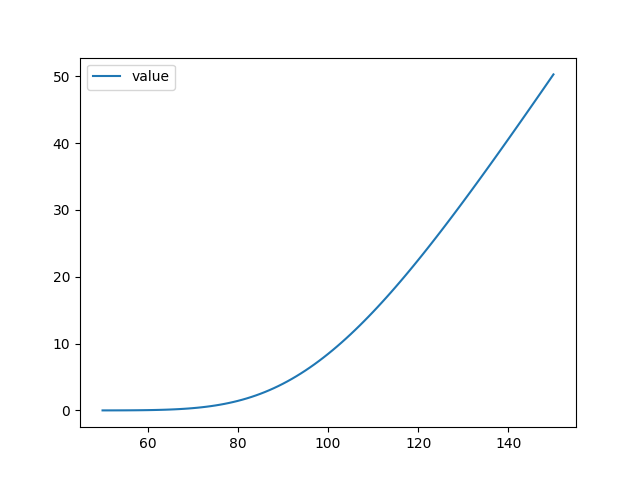

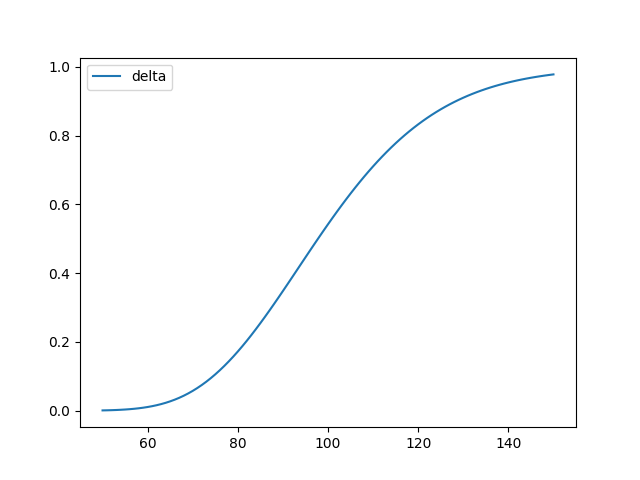

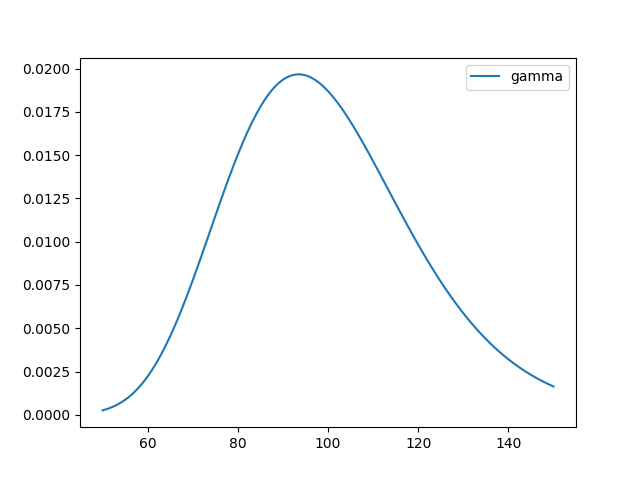

In [4]:
%matplotlib widget
# %matplotlib inline


# Test black_scholes_call
spot = np.linspace(50,150,101,True)
vol = 0.15
strike = 100
time = 1
expiry = 3
value, delta, gamma = black_scholes_call(time, spot, vol, strike, expiry, calc_gamma=True)

plt.figure() 
plt.plot(spot, value, label = 'value')
plt.legend(loc = 'best')
plt.show()
 
plt.figure() 
plt.plot(spot, delta, label='delta')
plt.legend(loc='best')
plt.show()
 
plt.figure() 
plt.plot(spot, gamma, label='gamma')
plt.legend(loc='best')
plt.show()

### A pricer for a call hedged with spot

In [5]:
def black_scholes_call_hedged(asof, asset_spot, asset_vol, option_strike, option_expiry, hedge_cash, hedge_delta):
    '''
    Calculate the value and delta  of a call option in Black-Scholes model with a hedge. The hedge is hedge_cash + hedge_delta * spot
    Assume zero rates and dividend yield
    One of the arguments could be a numpy array
    asof            : observation time in years, "little t" (normally 0 but useful to have as an input for hedging sim
                      as it moves forward while expiry stays fixed)
    asset_spot      : asset spot
    asset_vol       : asset lognormal volatility
    option_strike   : option strike
    option_expiry   : option expiry in years, "large T"
    hedge_cash      : the amount of cash we hold as a hedge in this position
    hedge_delta     : the amount of stock we hold as a hedge in this position
 
    Returns:        : (value, delta) of a hedged call position
    '''
    unhedged_call_value, unhedged_call_delta, _ = black_scholes_call(asof, asset_spot, asset_vol, option_strike, option_expiry)
    return (unhedged_call_value - hedge_delta * asset_spot - hedge_cash,
        unhedged_call_delta - hedge_delta)

### Check if our hedged call pricer loos as expected

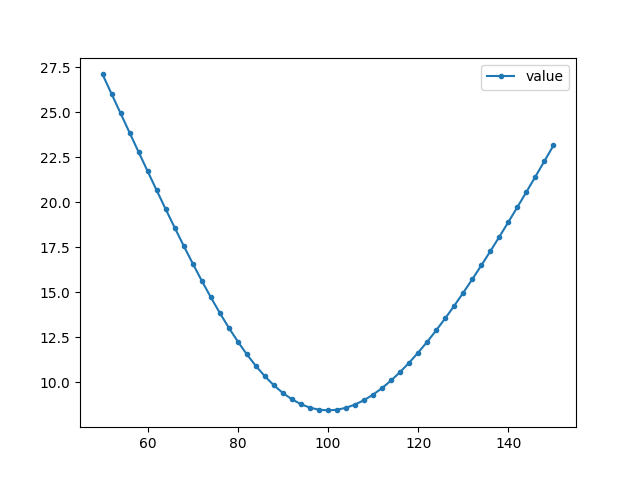

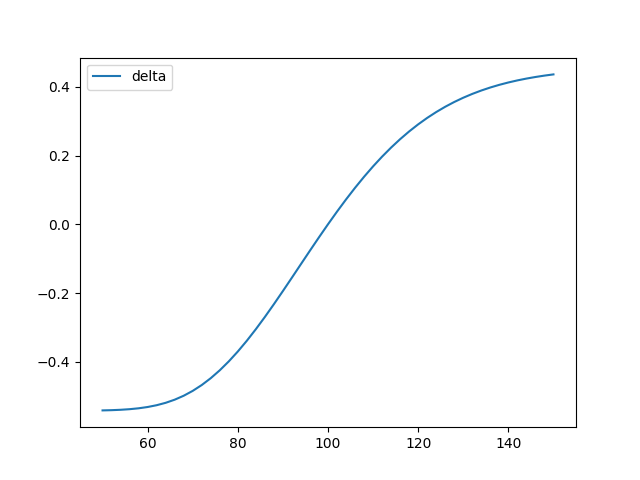

In [6]:
# Test black_scholes_call_hedged
spot = np.linspace(50,150,51,True)
vol = 0.15
strike = 100
time = 1
expiry = 3

# figure out the hedge for initial spot, spot_0
spot_0 = 100
value_0, delta_0 = black_scholes_call_hedged(time, spot_0, vol, strike, expiry, hedge_cash = 0, hedge_delta = 0)

hedge_cash_0 = - delta_0 * spot_0 # how much cash we need to buy our hedge
value, delta = black_scholes_call_hedged(time, spot, vol, strike, expiry, hedge_cash_0, delta_0)

plt.figure() 
plt.plot(spot, value, '.-', label = 'value')
plt.legend(loc = 'best')
plt.show()
 
plt.figure()
plt.plot(spot, delta, label='delta')
plt.legend(loc='best')
plt.show()
 


### A method to calculate new hedges when the spot moves to a new level

In [7]:
def calculate_hedges(asof, new_asset_spot, asset_vol, option_strike, option_expiry, current_hedge_cash, current_hedge_delta):

    '''
    Calculate a new hedge, new_hedge_cash and new_hedge_delta, when the underlying moved to new_spot, for a currently-hedged call option
    Assume zero rates and dividend yield
    One of the arguments could be a numpy array
    asof            : observation time in years, "little t" (normally 0 but useful to have as an input for hedging sim
                      as it moves forward while expiry stays fixed)
    new_asset_spot  : a new level of of the underlying
    asset_vol       : asset lognormal volatility
    option_strike   : option strike
    option_expiry   : option expiry in years, "large T"
    current_hedge_cash      : the amount of cash we should hold, for the new spot, to be hedged at the new spot
    new_hedge_delta : the amount of stock we should hold, for the new spot, to be hedged at the new spot
 
    Returns:        : (new_hedge_cash, new_hedge_delta) so that the position is hedged for the new spot
    '''
    _, new_delta = black_scholes_call_hedged(asof, new_asset_spot, asset_vol, option_strike, option_expiry, current_hedge_cash, current_hedge_delta)
    new_hedge_cash = - new_delta * new_asset_spot + current_hedge_cash 
    new_hedge_delta = new_delta + current_hedge_delta
    return new_hedge_cash, new_hedge_delta

### The main event

We assume a scenario where the spot moves 100 to 80 to 120 and we keep it delta-hedged. We plot the values of the position across a range of possible scenarions (for the spot from 50 to 150)

_Try different scenarious for the spot or add more moves_

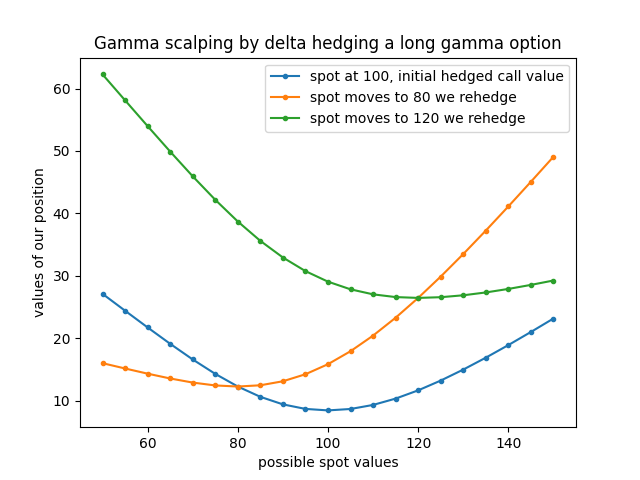

In [8]:
# Test black_scholes_call_hedged
spot = np.linspace(50,150,21,True)
vol = 0.15
strike = 100
time = 1
expiry = 3

# start with spot at 100, calculate hedgeing parameters and the value of the hedged position across a range of spots
current_spot = 100
current_hedge_cash = 0
current_hedge_delta = 0
hedge_cash_0, hedge_delta_0 = calculate_hedges(time, current_spot, vol, strike, expiry, current_hedge_cash = current_hedge_cash, current_hedge_delta = current_hedge_delta)
value_0, delta_0 = black_scholes_call_hedged(time, spot, vol, strike, expiry, hedge_cash_0, hedge_delta_0)


# How the spot moves to 80. Do the same
current_spot = 80
current_hedge_cash = hedge_cash_0
current_hedge_delta = hedge_delta_0
hedge_cash_1, hedge_delta_1 = calculate_hedges(time, current_spot, vol, strike, expiry, current_hedge_cash = current_hedge_cash, current_hedge_delta = current_hedge_delta)
value_1, delta_1 = black_scholes_call_hedged(time, spot, vol, strike, expiry, hedge_cash_1, hedge_delta_1)

# How the spot moves to 120. Do the same
current_spot = 120
current_hedge_cash = hedge_cash_1
current_hedge_delta = hedge_delta_1
hedge_cash_2, hedge_delta_2 = calculate_hedges(time, current_spot, vol, strike, expiry, current_hedge_cash = current_hedge_cash, current_hedge_delta = current_hedge_delta)
value_2, delta_2 = black_scholes_call_hedged(time, spot, vol, strike, expiry, hedge_cash_2, hedge_delta_2)


plt.figure() 
plt.plot(spot, value_0, '.-', label = 'spot at 100, initial hedged call value')
plt.plot(spot, value_1, '.-', label = 'spot moves to 80 we rehedge')
plt.plot(spot, value_2, '.-', label = 'spot moves to 120 we rehedge')
plt.xlabel('possible spot values')
plt.ylabel('values of our position')
plt.title('Gamma scalping by delta hedging a long gamma option')
plt.legend(loc = 'best')
plt.show()
 